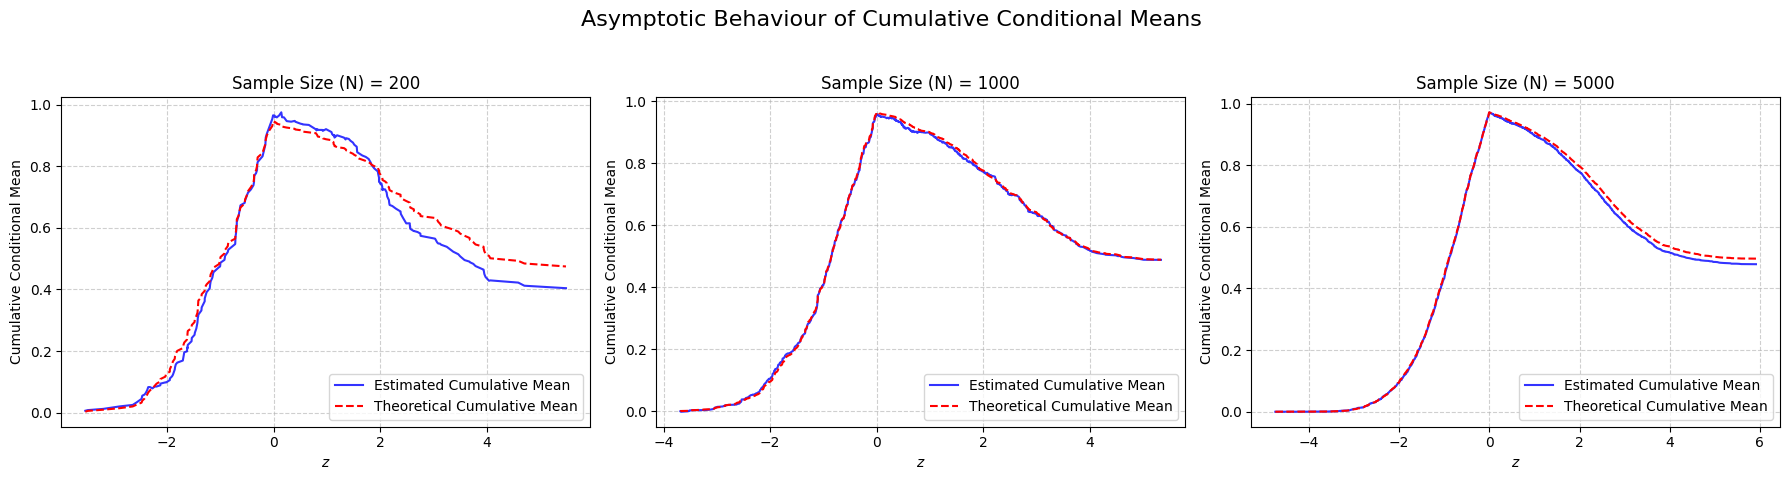

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# --- Step 1: Define model ---
# Model: SETAR(2;1;1)
# X_t = phi_1_0 + phi_1_1*X_{t-1} + e_t,  if X_{t-1} <= r
# X_t = phi_2_0 + phi_2_1*X_{t-1} + e_t,  if X_{t-1} > r

SETAR_PARAMS = {
    'phi1': [3, 0.7],  # [phi_1_0, phi_1_1]
    'phi2': [-0.3, -0.3], # [phi_2_0, phi_2_1]
    'r': 0.0,            # (threshold)
    'sigma': 1.0         # std of noise
}

# --- Step 2: Theoritical M(x) ---
# M(x) = E{X_{t+1} | X_t = x}
def theoretical_conditional_mean(x, params):
    """Compute Theoritical Value by Model Paramters"""
    if x <= params['r']:
        return params['phi1'][0] + params['phi1'][1] * x
    else:
        return params['phi2'][0] + params['phi2'][1] * x

# --- 步骤 3: 模拟SETAR过程 ---
def simulate_setar(n_points, params):
    """Simulate SETAR(2;1;1) Process"""
    x = np.zeros(n_points + 100) # (burn-in period)
    noise = np.random.normal(0, params['sigma'], n_points + 100)
    
    for t in range(1, n_points + 100):
        if x[t-1] <= params['r']:
            x[t] = params['phi1'][0] + params['phi1'][1] * x[t-1] + noise[t]
        else:
            x[t] = params['phi2'][0] + params['phi2'][1] * x[t-1] + noise[t]
            
    return x[100:] # 返回去除燃烧期后的序列

# --- Step 4: Comparision ---
def run_and_plot_cumulative_means(ax, n_points, params):
    # simulate data
    series = simulate_setar(n_points, params)
    
    # set data pair (X_t, X_{t+1})
    x_t = series[:-1]
    x_t_plus_1 = series[1:]
    
    # Sort data based on x_t for cumulative calculations
    sort_indices = np.argsort(x_t)
    x_t_sorted = x_t[sort_indices]
    x_t_plus_1_sorted = x_t_plus_1[sort_indices]
    
    # 1. Calculate estimated cumulative conditional means
    estimated_cumulative_mean = np.cumsum(x_t_plus_1_sorted) / n_points
    
    # 2. Compute theoretical cumulative conditional means 
    # Apply theoretical function M(x) to sorted x_t
    m_x_values = np.array([theoretical_conditional_mean(x, params) for x in x_t_sorted])
    theoretical_cumulative_mean = np.cumsum(m_x_values) / n_points
    
    # 3. Plot
    ax.plot(x_t_sorted, estimated_cumulative_mean, label='Estimated Cumulative Mean', color='blue', alpha=0.8)
    ax.plot(x_t_sorted, theoretical_cumulative_mean, label='Theoretical Cumulative Mean', color='red', linestyle='--')
    ax.set_title(f'Sample Size (N) = {n_points}')
    ax.set_xlabel('$z$')
    ax.set_ylabel('Cumulative Conditional Mean')
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()

# --- Step 5: Explore Aymptotic Behaviour ---
# try on different sample sizes
sample_sizes = [200, 1000, 5000]

fig, axes = plt.subplots(1, len(sample_sizes), figsize=(18, 5))
fig.suptitle('Asymptotic Behaviour of Cumulative Conditional Means ', fontsize=16)

for i, n in enumerate(sample_sizes):
    run_and_plot_cumulative_means(axes[i], n, SETAR_PARAMS)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

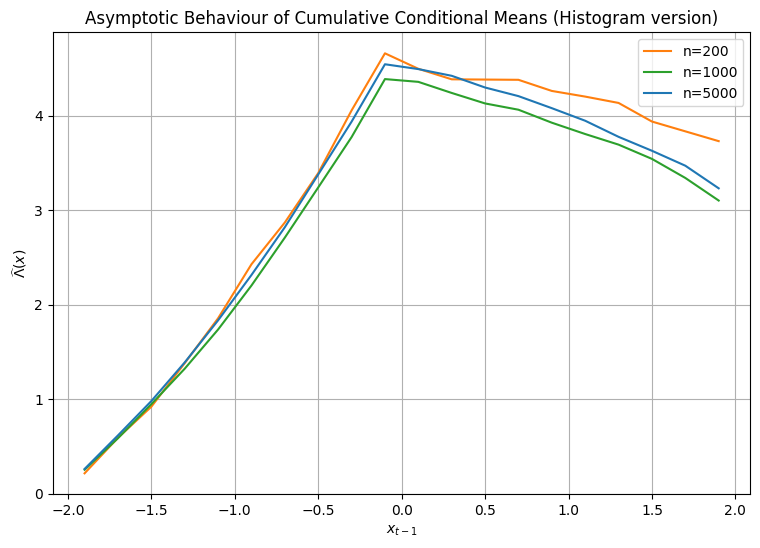

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# ① 估计 CCM（直方图版本）：逐行对应你提供的 R 代码
# ============================================================
def estimate_ccm_hist(
    x,
    n_bin=20,
    breaks=None,           # 若为 None，按 R 代码默认用 [-2,2] 等分
    x_range=(-2.0, 2.0),   # 仅在 breaks=None 时生效
    min_bin_count=5,       # 与 R 脚本一致：任一 bin < 5 则停止（strict=True 时）
    c_alpha=1.273,         # Table 3.1 的 95% 系数
    strict=True            # True: 任一 bin 不足即报错；False: 跳过稀疏 bin
):
    """
    用 histogram 回归估计 cumulative conditional mean (CCM) 及 95% 置信带。
    完全对应 R 脚本：
      - breaks <- seq(-2,2,len=n.bin+1)
      - L <- split(x[-1], cut(x[-length(x)], breaks))
      - lambda[i] <- mean(x.bin)
      - f.hat[i] <- (n.bin*h)^(-1) * length(x.bin)
      - gamma[i] <- sum((x.bin - lambda[i])^2) / length(x.bin)
      - Lambda <- cumsum(lambda*h)
      - h.hat[i] <- gamma[i]/f.hat[i]
      - H.hat <- cumsum(h.hat*h)
      - 置信带：Lambda ± c.alpha * n.bin^(-0.5) * H.hat.b^(0.5) * (1 + H.hat/H.hat.b)
    """
    x = np.asarray(x).ravel()
    if x.size < 3:
        raise ValueError("x 长度太短")

    # breaks <- seq(-2,2,len=n.bin+1)
    if breaks is None:
        breaks = np.linspace(x_range[0], x_range[1], n_bin + 1, dtype=float)
    else:
        breaks = np.asarray(breaks, dtype=float)
        n_bin = len(breaks) - 1
    h = breaks[1] - breaks[0]

    # 条件在 x_{t-1} 上分箱
    prev = x[:-1]   # x_{t-1}
    nxt  = x[1:]    # x_t
    # 贴近 R 的 cut(right=TRUE)
    idx = np.digitize(prev, breaks, right=True) - 1
    idx[idx < 0] = 0
    idx[idx >= n_bin] = n_bin - 1

    lambda_hat = np.full(n_bin, np.nan)  # lambda
    f_hat      = np.full(n_bin, np.nan)  # f.hat
    gamma_hat  = np.full(n_bin, np.nan)  # gamma
    counts = np.bincount(idx, minlength=n_bin)

    # 与 R 一致：若 strict=True，任一 bin < min_bin_count 则停止
    if strict and np.any(counts < min_bin_count):
        bad = np.where(counts < min_bin_count)[0]
        raise ValueError(
            f"Stopped: There are less than {min_bin_count} points in bin(s) {bad.tolist()}.\n"
            "请增大样本量、减少 n_bin、或放宽 breaks/x_range；或者设 strict=False 以跳过稀疏 bin。"
        )

    # 逐 bin 计算 lambda / f.hat / gamma
    for i in range(n_bin):
        mask = (idx == i)
        c = counts[i]
        if c < min_bin_count and not strict:
            continue
        x_bin = nxt[mask]
        lam = x_bin.mean()
        lambda_hat[i] = lam

        # 严格照抄 R 脚本：(n.bin*h)^(-1) * length(x.bin)
        f_hat[i] = c / (n_bin * h)

        # 局部方差
        gamma_hat[i] = np.mean((x_bin - lam) ** 2)

    # 去掉跳过的 bin（仅 strict=False 时可能出现）
    valid = ~np.isnan(lambda_hat)
    if valid.sum() < 2:
        raise ValueError("有效 bin 过少，无法累计。请调整 n_bin/breaks 或增大样本。")

    lambda_hat = lambda_hat[valid]
    f_hat      = f_hat[valid]
    gamma_hat  = gamma_hat[valid]

    # Lambda <- cumsum(lambda*h)
    Lambda = np.cumsum(lambda_hat * h)

    # h.hat[i] <- gamma[i]/f.hat[i]; H.hat <- cumsum(h.hat*h)
    h_hat = gamma_hat / f_hat
    H_hat = np.cumsum(h_hat * h)

    # 置信带
    H_hat_b = H_hat[-1]
    n_bin_eff = int(valid.sum())
    factor = c_alpha * (n_bin_eff ** -0.5) * (H_hat_b ** 0.5)
    Lambda_lower = Lambda - factor * (1.0 + H_hat / H_hat_b)
    Lambda_upper = Lambda + factor * (1.0 + H_hat / H_hat_b)

    mids_full = 0.5 * (breaks[:-1] + breaks[1:])
    x_mid = mids_full[valid]

    meta = {
        "breaks": breaks, "h": h, "valid_mask": valid, "n_bin_eff": n_bin_eff,
        "lambda_hat": lambda_hat, "f_hat": f_hat, "gamma_hat": gamma_hat,
        "H_hat": H_hat, "H_hat_b": H_hat_b, "counts": counts
    }
    return x_mid, Lambda, Lambda_lower, Lambda_upper, meta


# ============================================================
# ② 画图辅助：可叠加多个样本量
# ============================================================
def plot_ccm_hist(x_mid, Lambda, lower, upper, label=None, ax=None, fill_alpha=0.16):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(x_mid, Lambda, label=label or "Estimated CCM")
    ax.fill_between(x_mid, lower, upper, alpha=fill_alpha, label=(label and f"{label} 95% CI") or "95% CI")
    ax.set_xlabel(r"$x_{t-1}$")
    ax.set_ylabel(r"$\widehat{\Lambda}(x)$")
    ax.grid(True)
    if label is not None:
        ax.legend()
    return ax


# ============================================================
# ③（可选）示例模拟：SETAR(2,1,1) —— 你也可以替换为你自己的 x_full
# ============================================================
def simulate_setar(n, seed=0):
    np.random.seed(seed)
    x = np.zeros(n)
    eps = np.random.normal(0, 1, n)
    for t in range(1, n):
        if x[t - 1] <= 0:
            x[t] = 0.7 * x[t - 1] + 3 + eps[t]          # regime 1
        else:
            x[t] = -0.3 * x[t - 1] - 0.3 + eps[t]      # regime 2
    return x


# ============================================================
# ④ 合起来：比较不同样本量的渐进行为（核心调用示例）
# ============================================================
# 如果你已有完整序列 x_full（来自你的 Part 2/3 仿真或真实数据），
# 设置 use_simulation = False，并把 x_full 传入下面的变量即可。
use_simulation = True
sample_sizes = [200, 1000, 5000]   # 你可以修改样本量列表
n_bin = 20
breaks = None          # 或者自定义 array，比如 np.linspace(-3, 3, n_bin+1)
x_range = (-2.0, 2.0)  # 仅在 breaks=None 时生效
strict_small_n = False # 小样本时可设为 False，避免少样本 bin 直接报错

if use_simulation:
    # 用同一随机轨迹的前缀来体现“样本量增加”的收敛
    x_full = simulate_setar(max(sample_sizes), seed=0)
else:
    # TODO: 替换成你 notebook 中已有的完整序列变量
    x_full = x  # e.g., x 是你前面生成/读取的完整序列

fig, ax = plt.subplots(figsize=(9, 6))
colors = ["tab:orange", "tab:green", "tab:blue", "tab:red", "tab:purple"]

for k, n in enumerate(sample_sizes):
    x_n = x_full[:n]
    try:
        x_mid, Lam, Lo, Up, meta = estimate_ccm_hist(
            x_n, n_bin=n_bin, breaks=breaks, x_range=x_range,
            strict=(strict_small_n if n == min(sample_sizes) else True)
        )
    except ValueError as e:
        print(f"[n={n}] {e}")
        continue
    ax.plot(x_mid, Lam, color=colors[k % len(colors)], label=f"n={n}")
    # ax.fill_between(x_mid, Lo, Up, color=colors[k % len(colors)], alpha=0.12)

ax.set_title("Asymptotic Behaviour of Cumulative Conditional Means (Histogram version)")
ax.set_xlabel(r"$x_{t-1}$"); ax.set_ylabel(r"$\widehat{\Lambda}(x)$")
ax.grid(True); ax.legend()
plt.show()


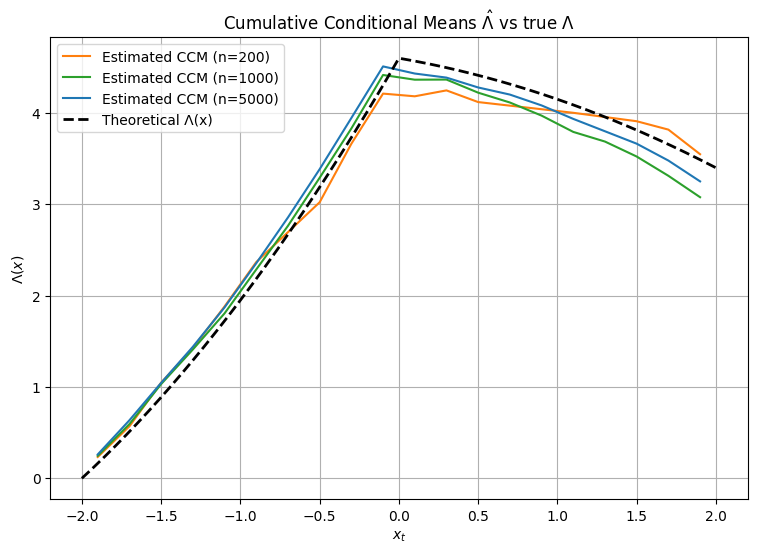

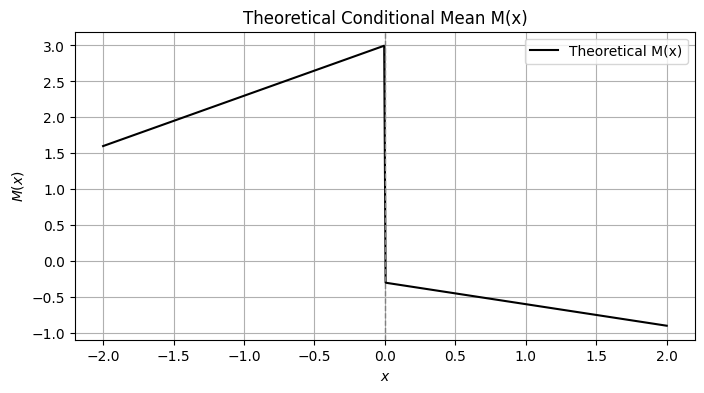

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# ① 估计 CCM（直方图版本）：逐行对应你提供的 R 代码
# ============================================================
def estimate_ccm_hist(
    x,
    n_bin=20,
    breaks=None,           # 若为 None，按 R 代码默认用 [-2,2] 等分
    x_range=(-2.0, 2.0),   # 仅在 breaks=None 时生效
    min_bin_count=5,       # 与 R 脚本一致：任一 bin < 5 则停止（strict=True 时）
    c_alpha=1.273,         # Table 3.1 的 95% 系数
    strict=True            # True: 任一 bin 不足即报错；False: 跳过稀疏 bin
):
    x = np.asarray(x).ravel()
    if x.size < 3:
        raise ValueError("x 长度太短")

    # breaks <- seq(-2,2,len=n.bin+1)
    if breaks is None:
        breaks = np.linspace(x_range[0], x_range[1], n_bin + 1, dtype=float)
    else:
        breaks = np.asarray(breaks, dtype=float)
        n_bin = len(breaks) - 1
    h = breaks[1] - breaks[0]

    # 条件在 x_{t-1} 上分箱
    prev = x[:-1]   # x_{t-1}
    nxt  = x[1:]    # x_t
    # 贴近 R 的 cut(right=TRUE)
    idx = np.digitize(prev, breaks, right=True) - 1
    idx[idx < 0] = 0
    idx[idx >= n_bin] = n_bin - 1

    lambda_hat = np.full(n_bin, np.nan)  # lambda
    f_hat      = np.full(n_bin, np.nan)  # f.hat
    gamma_hat  = np.full(n_bin, np.nan)  # gamma
    counts = np.bincount(idx, minlength=n_bin)

    # 与 R 一致：若 strict=True，任一 bin < min_bin_count 则停止
    if strict and np.any(counts < min_bin_count):
        bad = np.where(counts < min_bin_count)[0]
        raise ValueError(
            f"Stopped: There are less than {min_bin_count} points in bin(s) {bad.tolist()}.\n"
            "请增大样本量、减少 n_bin、或放宽 breaks/x_range；或者设 strict=False 以跳过稀疏 bin。"
        )

    # 逐 bin 计算 lambda / f.hat / gamma
    for i in range(n_bin):
        mask = (idx == i)
        c = counts[i]
        if c < min_bin_count and not strict:
            continue
        x_bin = nxt[mask]
        lam = x_bin.mean()
        lambda_hat[i] = lam

        # 严格照抄 R 脚本：(n.bin*h)^(-1) * length(x.bin)
        f_hat[i] = c / (n_bin * h)

        # 局部方差
        gamma_hat[i] = np.mean((x_bin - lam) ** 2)

    # 去掉跳过的 bin（仅 strict=False 时可能出现）
    valid = ~np.isnan(lambda_hat)
    if valid.sum() < 2:
        raise ValueError("有效 bin 过少，无法累计。请调整 n_bin/breaks 或增大样本。")

    lambda_hat = lambda_hat[valid]
    f_hat      = f_hat[valid]
    gamma_hat  = gamma_hat[valid]

    # Lambda <- cumsum(lambda*h)
    Lambda = np.cumsum(lambda_hat * h)

    # h.hat[i] <- gamma[i]/f.hat[i]; H.hat <- cumsum(h.hat*h)
    h_hat = gamma_hat / f_hat
    H_hat = np.cumsum(h_hat * h)

    # 置信带
    H_hat_b = H_hat[-1]
    n_bin_eff = int(valid.sum())
    factor = c_alpha * (n_bin_eff ** -0.5) * (H_hat_b ** 0.5)
    Lambda_lower = Lambda - factor * (1.0 + H_hat / H_hat_b)
    Lambda_upper = Lambda + factor * (1.0 + H_hat / H_hat_b)

    mids_full = 0.5 * (breaks[:-1] + breaks[1:])
    x_mid = mids_full[valid]

    meta = {
        "breaks": breaks, "h": h, "valid_mask": valid, "n_bin_eff": n_bin_eff,
        "lambda_hat": lambda_hat, "f_hat": f_hat, "gamma_hat": gamma_hat,
        "H_hat": H_hat, "H_hat_b": H_hat_b, "counts": counts
    }
    return x_mid, Lambda, Lambda_lower, Lambda_upper, meta


# ============================================================
# ② 理论曲线：M(x) 与 Λ(x)=∫_a^x M(u)du
#    这里给出 SETAR(2,1,1)（阈值 c）的一般表达：
#    x <= c:  M(x) = phi10 + phi11*x
#    x >  c:  M(x) = phi20 + phi21*x
#    Λ 与 CCM 的“下限”一致：a = breaks[0]
# ============================================================
def setar_theory_curves(breaks, c=0.0, phi10=3, phi11=0.7, phi20=-0.3, phi21=-0.3, num=400):
    a = float(breaks[0])
    x_dense = np.linspace(breaks[0], breaks[-1], num)

    # 条件均值 M(x)
    M_true = np.where(
        x_dense <= c,
        phi10 + phi11 * x_dense,
        phi20 + phi21 * x_dense
    )

    # 反导函数（原函数为分段线性，积分为分段二次）
    # Regime 1: F1(u) = phi10*u + 0.5*phi11*u^2
    # Regime 2: F2(u) = phi20*u + 0.5*phi21*u^2
    def F1(u): return phi10*u + 0.5*phi11*(u**2)
    def F2(u): return phi20*u + 0.5*phi21*(u**2)

    # Λ_true(x) = ∫_a^x M(u) du
    Lambda_true = np.empty_like(x_dense)
    for i, x in enumerate(x_dense):
        if x <= c:
            # 若 a <= x <= c
            if a <= c:
                Lambda_true[i] = F1(x) - F1(a)
            else:
                # 极端情形：若 a>c，则区间完全在右侧，不常见，但仍处理
                Lambda_true[i] = F2(x) - F2(a)
        else:
            # x > c
            if a <= c:
                Lambda_true[i] = (F1(c) - F1(a)) + (F2(x) - F2(c))
            else:
                Lambda_true[i] = F2(x) - F2(a)

    return x_dense, M_true, Lambda_true


# ============================================================
# ③ 示例：对比不同样本量的 CCM（估计）与 理论 Λ(x)
#    若你已有 x_full，则把 use_simulation=False 并传入 x_full
# ============================================================
def simulate_setar(n, seed=0, c=0.0, phi10=3, phi11=0.7, phi20=-0.3, phi21=-0.3):
    rng = np.random.default_rng(seed)
    x = np.zeros(n)
    eps = rng.normal(0, 1, n)
    for t in range(1, n):
        if x[t - 1] <= c:
            x[t] = phi10 + phi11 * x[t - 1] + eps[t]
        else:
            x[t] = phi20 + phi21 * x[t - 1] + eps[t]
    return x

# ---- 参数（请与你的数据/仿真一致）----
setar_params = dict(c=0.0, phi10=3, phi11=0.7, phi20=-0.3, phi21=-0.3)

use_simulation = True   # 若已有 x_full，请设为 False 并提供 x_full
sample_sizes = [200, 1000, 5000]
n_bin = 20
breaks = None           # 或自定义 np.linspace(-3,3,n_bin+1)
x_range = (-2.0, 2.0)   # 仅在 breaks=None 时生效
strict_small_n = False  # 小样本时允许跳过稀疏 bin

# ---- 数据准备 ----
if use_simulation:
    x_full = simulate_setar(max(sample_sizes), seed=0, **setar_params)
else:
    # TODO: 替换为你 notebook 中的完整序列
    x_full = x_full  # 确保这个变量存在

# ---- 先拿到 breaks（为理论 Λ 设同一积分下限 a）----
#     与 R 脚本一致，默认 [-2,2]。若你上面自定义了 breaks，这里也会同步。
_dummy_breaks = breaks if breaks is not None else np.linspace(x_range[0], x_range[1], n_bin + 1)
x_th, M_th, Lambda_th = setar_theory_curves(_dummy_breaks, **setar_params)

# ---- 画图：估计的 CCM vs 理论 Λ(x) ----
fig, ax = plt.subplots(figsize=(9, 6))
colors = ["tab:orange", "tab:green", "tab:blue", "tab:red", "tab:purple"]

for k, n in enumerate(sample_sizes):
    x_n = x_full[:n]
    try:
        x_mid, Lam, Lo, Up, meta = estimate_ccm_hist(
            x_n, n_bin=n_bin, breaks=breaks, x_range=x_range,
            strict=(strict_small_n if n == min(sample_sizes) else True)
        )
    except ValueError as e:
        print(f"[n={n}] {e}")
        continue
    ax.plot(x_mid, Lam, color=colors[k % len(colors)], label=f"Estimated CCM (n={n})")
    # ax.fill_between(x_mid, Lo, Up, color=colors[k % len(colors)], alpha=0.12)

# 理论 Λ(x) 叠加（虚线黑色）
ax.plot(x_th, Lambda_th, "k--", linewidth=2.0, label="Theoretical Λ(x)")

ax.set_title("Cumulative Conditional Means $\hat\Lambda$ vs true $\Lambda$")
ax.set_xlabel(r"$x_{t}$"); ax.set_ylabel(r"$\Lambda(x)$")
ax.grid(True); ax.legend(loc="best")
plt.show()

# ---- 可选：单独画理论 M(x)（条件均值）以供参考 ----
fig2, ax2 = plt.subplots(figsize=(8, 4))
ax2.plot(x_th, M_th, "k-", label="Theoretical M(x)")
ax2.axvline(setar_params["c"], color="gray", linestyle="--", linewidth=1)
ax2.set_title("Theoretical Conditional Mean M(x)")
ax2.set_xlabel(r"$x$")
ax2.set_ylabel(r"$M(x)$")
ax2.grid(True); ax2.legend()
plt.show()


[n=200] Stopped: <5 points in bins [6, 13, 14, 16].


AttributeError: 'Axes' object has no attribute 'yticks'

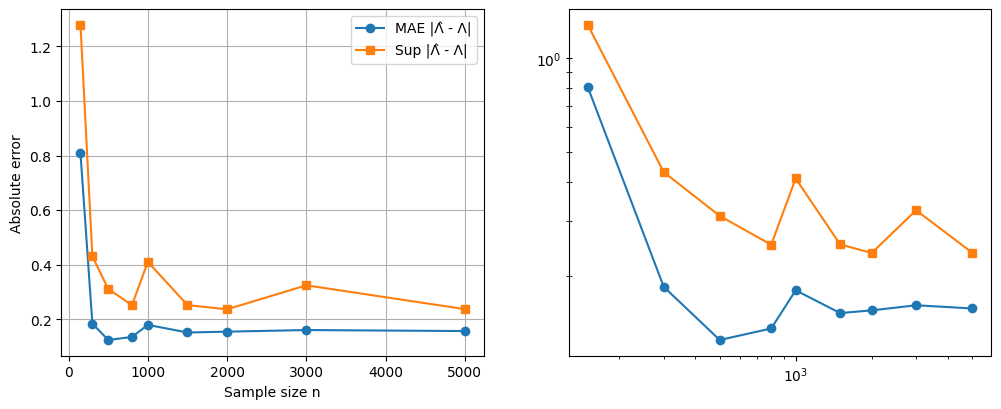

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker


import numpy as np
import matplotlib.ticker as mticker

def set_dense_log_yticks(ax, values, multiples=(1,2,3,5,7), pad_decades=0):
    """
    Force dense y-ticks on a log-scale axis with explicit labels.
    values: list/array of positive numbers (e.g., mae_list + sup_list)
    multiples: which tick multipliers within each decade
    pad_decades: extend range by N decades on each side (optional)
    """
    vals = np.asarray(values, dtype=float)
    vals = vals[vals > 0]
    if vals.size == 0:
        return

    vmin, vmax = vals.min(), vals.max()
    lo = int(np.floor(np.log10(vmin))) - int(pad_decades)
    hi = int(np.ceil(np.log10(vmax))) + int(pad_decades)

    ticks = []
    for p in range(lo, hi + 1):
        decade = 10.0 ** p
        for m in multiples:
            ticks.append(m * decade)

    # keep ticks within a small padded range
    ticks = [t for t in ticks if (vmin / 1.1) <= t <= (vmax * 1.1)]
    if not ticks:
        return

    ax.set_yticks(ticks)
    # label every tick (scientific notation)
    ax.set_yticklabels([f"{t:.1e}" for t in ticks])
    ax.tick_params(axis='y', which='both', direction='inout', length=4)
    # keep grid for both major/minor spacing on log axis
    ax.grid(True, which='both', axis='y', linestyle=':', alpha=0.6)

# --- call it for your log–log subplot ---


# --- If you already set these earlier, keep yours and delete this block ---
def simulate_setar(n, seed=0, c=0.0, phi10=0.0, phi11=0.5, phi20=-1.0, phi21=0.9):
    rng = np.random.default_rng(seed)
    x = np.zeros(n)
    eps = rng.normal(0, 1, n)
    for t in range(1, n):
        if x[t - 1] <= c:
            x[t] = phi10 + phi11 * x[t - 1] + eps[t]
        else:
            x[t] = phi20 + phi21 * x[t - 1] + eps[t]
    return x

# Theoretical Λ(x) at arbitrary x (lower limit a = breaks[0], same as CCM)
def theoretical_lambda_at(x_pts, breaks, c=0.0, phi10=0.0, phi11=0.5, phi20=-1.0, phi21=0.9):
    x = np.asarray(x_pts, dtype=float)
    a = float(breaks[0])
    F1 = lambda u: phi10*u + 0.5*phi11*u**2
    F2 = lambda u: phi20*u + 0.5*phi21*u**2
    out = np.empty_like(x)
    if a <= c:
        # piecewise: integrate left (regime 1) then right (regime 2)
        left_mask = (x <= c)
        out[left_mask]  = F1(x[left_mask]) - F1(a)
        out[~left_mask] = (F1(c) - F1(a)) + (F2(x[~left_mask]) - F2(c))
    else:
        # rare case: whole interval on right side
        out = F2(x) - F2(a)
    return out

# --- Your histogram CCM estimator (as defined before). If already defined, skip. ---
def estimate_ccm_hist(x, n_bin=20, breaks=None, x_range=(-2.0, 2.0), min_bin_count=5, c_alpha=1.273, strict=True):
    x = np.asarray(x).ravel()
    if breaks is None:
        breaks = np.linspace(x_range[0], x_range[1], n_bin + 1, dtype=float)
    else:
        breaks = np.asarray(breaks, dtype=float)
        n_bin = len(breaks) - 1
    h = breaks[1] - breaks[0]
    prev, nxt = x[:-1], x[1:]
    idx = np.digitize(prev, breaks, right=True) - 1
    idx[idx < 0] = 0
    idx[idx >= n_bin] = n_bin - 1
    counts = np.bincount(idx, minlength=n_bin)

    lam = np.full(n_bin, np.nan)
    fhat = np.full(n_bin, np.nan)
    ghat = np.full(n_bin, np.nan)
    if strict and np.any(counts < min_bin_count):
        bad = np.where(counts < min_bin_count)[0]
        raise ValueError(f"Stopped: <{min_bin_count} points in bins {bad.tolist()}.")
    for i in range(n_bin):
        mask = (idx == i)
        c = counts[i]
        if c < min_bin_count and not strict:
            continue
        x_bin = nxt[mask]
        lam[i]  = x_bin.mean()
        fhat[i] = c / (n_bin * h)
        ghat[i] = np.mean((x_bin - lam[i])**2)
    valid = ~np.isnan(lam)
    lam, fhat, ghat = lam[valid], fhat[valid], ghat[valid]
    mids_full = 0.5 * (breaks[:-1] + breaks[1:])
    x_mid = mids_full[valid]

    Lambda = np.cumsum(lam * h)
    hhat = ghat / fhat
    Hhat = np.cumsum(hhat * h)
    Hb = Hhat[-1]
    nb = int(valid.sum())
    factor = c_alpha * (nb**-0.5) * (Hb**0.5)
    Lo = Lambda - factor * (1 + Hhat / Hb)
    Up = Lambda + factor * (1 + Hhat / Hb)
    return x_mid, Lambda, Lo, Up, {"breaks": breaks}

# ---------------------- Convergence experiment ----------------------
# 1) Set your SETAR and binning params to match your notebook
# setar_params = dict(c=0.0, phi10=0.0, phi11=0.5, phi20=-1.0, phi21=0.9)
setar_params = dict(c=0.0, phi10=3, phi11=0.7, phi20=-0.3, phi21=-0.3)
n_bin   = 20
breaks  = None           # or np.linspace(-3,3,n_bin+1)
x_range = (-2.0, 2.0)
sample_sizes = [150, 200, 300, 500, 800, 1000, 1500, 2000, 3000, 5000]

# 2) Generate one long path and use prefixes to ensure comparability
x_long = simulate_setar(max(sample_sizes), seed=0, **setar_params)

# 3) Compute errors for each n (MAE and sup norm) against theoretical Λ at the same x_mid
mae_list, sup_list, n_list = [], [], []
for n in sample_sizes:
    try:
        # for the smallest n, allow skipping sparse bins; otherwise be strict
        strict = False if n == min(sample_sizes) else True
        x_mid, Lam, _, _, meta = estimate_ccm_hist(
            x_long[:n], n_bin=n_bin, breaks=breaks, x_range=x_range, strict=strict
        )
    except ValueError as e:
        print(f"[n={n}] {e}")
        continue
    br = meta["breaks"]
    Lam_true = theoretical_lambda_at(x_mid, br, **setar_params)
    err = np.abs(Lam - Lam_true)
    mae_list.append(np.mean(err))
    sup_list.append(np.max(err))
    n_list.append(n)

# 4) Plot: absolute error vs sample size
fig, ax = plt.subplots(1, 2, figsize=(12, 4.5))


# (a) Linear axes
ax[0].plot(n_list, mae_list, marker='o', label="MAE |Λ̂ - Λ|")
ax[0].plot(n_list, sup_list, marker='s', label="Sup |Λ̂ - Λ|")
ax[0].set_xlabel("Sample size n")
ax[0].set_ylabel("Absolute error")
ax[0].grid(True)
ax[0].legend()

# (b) Log–log (reveals rate visually). Add ~n^{-1/2} guideline.
# more y ticks on the log–log plot
from matplotlib.ticker import LogLocator, LogFormatter, NullFormatter

ax[1].yaxis.set_major_locator(LogLocator(base=10, subs=(1.0,2.0,3.0,5.0,7.0), numticks=200))
ax[1].yaxis.set_major_formatter(LogFormatter(base=10, labelOnlyBase=False))  # label all major ticks
ax[1].yaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(1,10)*0.1, numticks=1000))
ax[1].yaxis.set_minor_formatter(NullFormatter())
ax[1].tick_params(axis='y', which='both', direction='inout', length=4)

# ax[1].yaxis.set_major_locator(mticker.LogLocator(base=100, numticks=50))
# ax[1].yaxis.set_minor_locator(mticker.LogLocator(base=100, subs=np.arange(2,10)*0.1, numticks=120))
# ax[1].yaxis.set_minor_formatter(mticker.NullFormatter())
# ax[1].tick_params(axis='y', which='both', direction='inout', length=4)
# ax[1].yticks([1e-3, 1e-2, 1e-1, 1]) 

ax[1].loglog(n_list, mae_list, marker='o', label="MAE |Λ̂ - Λ|")
ax[1].loglog(n_list, sup_list, marker='s', label="Sup |Λ̂ - Λ|")
# guideline ~ n^{-1/2} through first MAE point
if len(n_list) > 0:
    k = mae_list[0] * (n_list[0]**0.5)
    guideline = [k / (ni**0.5) for ni in n_list]
    ax[1].loglog(n_list, guideline, linestyle='--', label="$n^{-1/2}$")
ax[1].set_xlabel("Sample size n (log)")
ax[1].set_ylabel("Absolute error (log)")
ax[1].grid(True, which='both')
ax[1].legend()

plt.suptitle("Convergence of CCM (Histogram) to Theoretical Λ(x)")
plt.tight_layout()
plt.show()


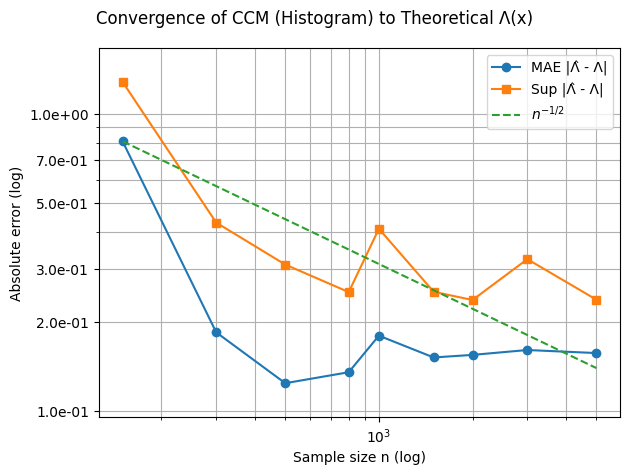

In [56]:
import numpy as np

plt.loglog(n_list, mae_list, marker='o', label="MAE |Λ̂ - Λ|")
plt.loglog(n_list, sup_list, marker='s', label="Sup |Λ̂ - Λ|")

if len(n_list) > 0:
    k = mae_list[0] * (n_list[0]**0.5)
    guideline = [k / (ni**0.5) for ni in n_list]
    plt.loglog(n_list, guideline, linestyle='--', label="$n^{-1/2}$")

plt.xlabel("Sample size n (log)")
plt.ylabel("Absolute error (log)")
plt.grid(True, which='both')
plt.legend()

# ----- make dense, labeled log y-ticks using plt API -----
# collect all positive values to determine a good tick range
_vals = np.array([*mae_list, *sup_list] + ([*guideline] if 'guideline' in locals() else []), dtype=float)
_vals = _vals[np.isfinite(_vals) & (_vals > 0)]
ymin, ymax = _vals.min()/1.3, _vals.max()*1.3

# build ticks like (1,2,3,5,7)*10^k across data range
_lo = int(np.floor(np.log10(ymin)))
_hi = int(np.ceil(np.log10(ymax)))
_multiples = np.array([1, 2, 3, 5, 7], float)

yticks = np.concatenate([_multiples * (10.0**p) for p in range(_lo, _hi + 1)])
yticks = yticks[(yticks >= ymin) & (yticks <= ymax)]

plt.ylim(ymin, ymax)
plt.yticks(yticks, [f"{t:.1e}" for t in yticks])  # <-- show values here

plt.suptitle("Convergence of CCM (Histogram) to Theoretical Λ(x)")
plt.tight_layout()
plt.show()
